In [238]:
import pandas as pd
import os.path as op
from os import sep
import nibabel as nb
import numpy as np
import json
import trimesh
import open3d as o3d
import open3d.visualization.rendering as rendering
import matplotlib.pylab as plt
from matplotlib import cm, colors, transforms
from utilities import files
import new_files
import tqdm.auto as tqdm
from copy import copy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, minmax_scale
from sklearn.manifold import MDS
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from brain_tools import *
import pickle
from functools import reduce
import itertools as it

dir_search = new_files.Files()

In [2]:
def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap
    )
    ax.set_ylim(1,0)
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
            ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
            ax.annotate(layer_labels[l_ix],[times[0]+0.01, th-0.01],size=15)
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()

In [56]:
def custom_draw_geometry(mesh, filename="render.png", visible=True, wh=[960, 960], save=True):
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=wh[0], height=wh[1], visible=visible)
    vis.add_geometry(mesh)
    vis.get_render_option().mesh_show_back_face=True
    vis.run()
    if save:
        vis.capture_screen_image(filename, do_render=True)
    vis.destroy_window()

In [68]:
def multiply_list(iterable):
    result = 1
    for item in iterable:
        result = result * item
    return result

In [134]:
def shift_cor(x1, x2, shifts=[-2, -1, 0, 1, 2], ret_sr=True):
    results = {}
    for s in shifts:
        if s < 0:
            x1 = x1[-s:]
            x2 = x2[:s]
        elif s > 0:
            x1 = x1[:-s]
            x2 = x2[s:]
        elif s == 0:
            x1 = x1
            x2 = x2
        sr = spearmanr(x1.flatten(), x2.flatten())
        results[s] = list(sr)
    max_corr_ix = np.argmax(np.abs(np.array(list(results.values()))[:, 0]))
    max_corr_key = list(results.keys())[max_corr_ix]
    max_corr_value = results[max_corr_key][0]
    if ret_sr:
        return max_corr_value, max_corr_key    
    else:
        return max_corr_value, results

In [128]:
dataset_location = "/home/common/bonaiuto/multiburst/derivatives/processed"
epoch_types = {
    "visual": [np.linspace(-0.2, 0.8, num=601), [-0.2, 0.2], -0.01],
    "motor": [np.linspace(-0.5, 0.5, num=601), [-0.2, 0.201], -0.2]
}

csd_files = dir_search.get_files(
    dataset_location, "*.npy", prefix="time_CSD_autoreject"
)

json_files = dir_search.get_files(
    dataset_location, "*.json", prefix="info"
)

info_dict = {}
for i in json_files:
    sub = i.split(sep)[-3]
    with open(i, "r") as fp:
        info_dict[sub] = json.load(fp)

In [129]:
csd_per_sub = [[j for j in csd_files if i in j] for i in ["sub-001", "sub-002"]]

In [130]:
label_names = {
    "L_4_ROI": "Left M1",
    "L_V1_ROI": "Left V1",
    "R_4_ROI": "Right M1",
    "R_V1_ROI": "Right V1"
}
all_results = {}
cut_results = {}
for csd_file in tqdm.tqdm(csd_files):
    epoch_type = [i for i in epoch_types.keys() if i in csd_file][0]
    subject = csd_file.split(sep)[-4]
    core_name = csd_file.split(sep)[-1].split("_")[-1].split(".")[0]
    info = info_dict[subject]
    atlas = pd.read_csv(info["atlas"])
    atlas_labels = np.load(info["atlas_colors_path"])
    ROI_labels = list(label_names.keys())
    vertex_num = np.arange(atlas_labels.shape[0])
    ROI_vertices = {i: vertex_num[[i == al.decode("utf=8") for al in atlas_labels]] for i in ROI_labels}
    times, sel, baseline_lim = epoch_types[epoch_type]
    csd_data = np.load(csd_file)
    true_CSD = {}
    for l in ROI_labels:
        true_CSD[l] = []
        for rv in ROI_vertices[l]:
            true_CSD[l].append(csd_data[rv, :, :])
    true_CSD = {i: np.array(true_CSD[i]) for i in ROI_labels}
    time_sel = np.where((times >= sel[0]) & (times <= sel[1]))[0]
    true_CSD_cut = {i: true_CSD[i][:,:, time_sel].reshape(true_CSD[i].shape[0], -1) for i in ROI_labels}
    all_results[core_name] = true_CSD
    cut_results[core_name] = true_CSD_cut

  0%|          | 0/12 [00:00<?, ?it/s]

In [63]:
v1 = {s: [i for i in list(cut_results.keys()) if s in i[0]] for s in ["sub-001", "sub-002"]}
m1 = {s: [i for i in list(cut_results.keys()) if s in i[0]] for s in ["sub-001", "sub-002"]}

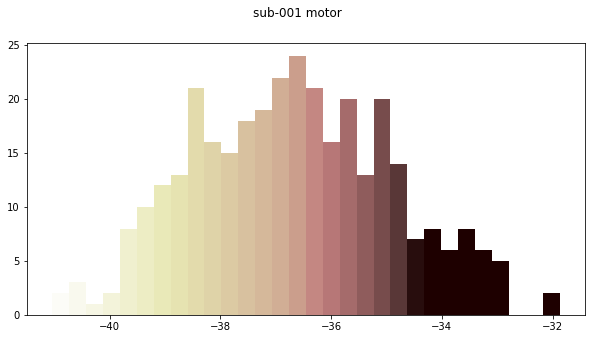

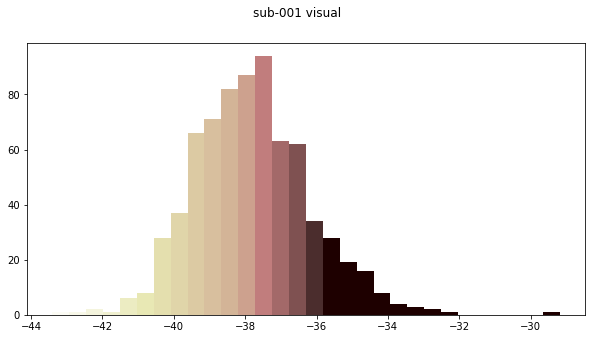

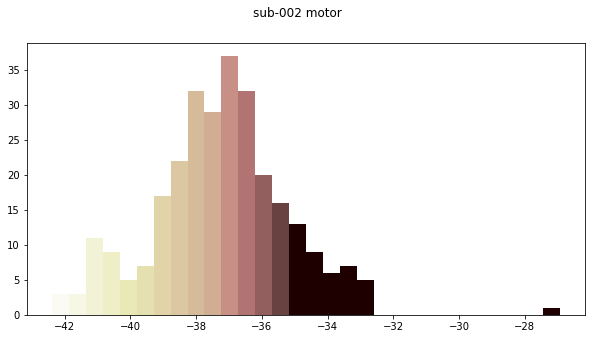

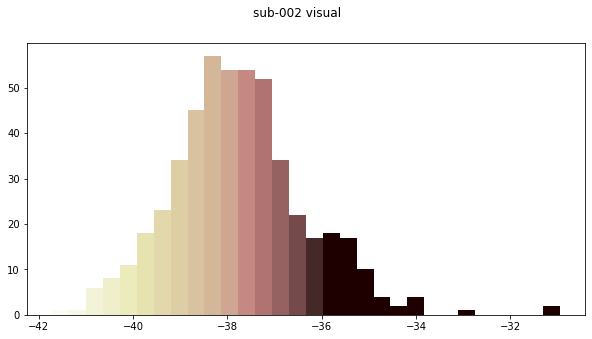

In [94]:
settings = {
    "motor": ["L_4_ROI"], 
    "visual": ["L_V1_ROI"]
}

subs = ["sub-001", "sub-002"]
ROI_vertices = {i: {} for i in subs}

results = {i: {} for i in subs}


for sub in subs:
    for epo_type in settings.keys():
        used_keys = [i for i in cut_results.keys() if all([(epo_type in i), (sub in i)])]
        max_vertex_val = [np.max(np.abs(cut_results[i][settings[epo_type][0]]), axis=1) for i in used_keys]
        max_vertex_val = np.log10(multiply_list(max_vertex_val))
        max_vertex_val[~np.isfinite(max_vertex_val)] = np.median(max_vertex_val)
        data_col, mappable = data_to_rgb(
            max_vertex_val, am_bins, "pink_r",
            np.percentile(max_vertex_val, 0),
            np.percentile(max_vertex_val, 90),
            vcenter=np.percentile(max_vertex_val, 50),
            ret_map=True
        )
        f, ax = plt.subplots(1, 1, figsize=(10, 5))
        hist, bins, barlist = ax.hist(max_vertex_val, bins=am_bins)
        for ix, xx in enumerate(barlist):
            plt.setp(xx, "facecolor", mappable.to_rgba(bins[ix+1]))
        f.suptitle("{} {}".format(sub, epo_type))
        
        roi_map = max_vertex_val >= np.percentile(max_vertex_val, 90)
        
        gray = np.array([0.5, 0.5, 0.5])
        brain = nb.load(info_dict[sub]["pial_ds_nodeep_inflated"])
        vertices, faces = brain.agg_data()
        atlas = pd.read_csv(info_dict[sub]["atlas"])
        atlas_labels = np.load(info_dict[sub]["atlas_colors_path"])
        ROI_labels = settings[epo_type]
        vertex_num = np.arange(atlas_labels.shape[0])
        ROI_vertices = {i: vertex_num[[i == al.decode("utf=8") for al in atlas_labels]] for i in ROI_labels}
        colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
        colours[ROI_vertices[settings[epo_type][0]][roi_map]] = data_col[roi_map,:3]
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
        mesh = mesh.as_open3d
        mesh.compute_vertex_normals(normalized=True)
        mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
        custom_draw_geometry(mesh, save=False)
        results[sub][settings[epo_type][0]] = roi_map

In [133]:
rois = np.array(list(settings.values())).flatten()
roi_csds = {}
for sub in results.keys():
    used_keys = [i for i in cut_results.keys() if sub in i]
    for k in used_keys:
        epo_type = k.split("-")[6]
        for r in rois:
            roi_csds[(sub, epo_type, r)] = cut_results[k][r][results[sub][r]]

In [202]:
rois = np.array(list(settings.values())).flatten()
all_roi_csds = {}
for sub in results.keys():
    used_keys = [i for i in all_results.keys() if sub in i]
    for k in used_keys:
        epo_type = k.split("-")[6]
        for r in rois:
            all_roi_csds[(sub, epo_type, r)] = all_results[k][r][results[sub][r]]

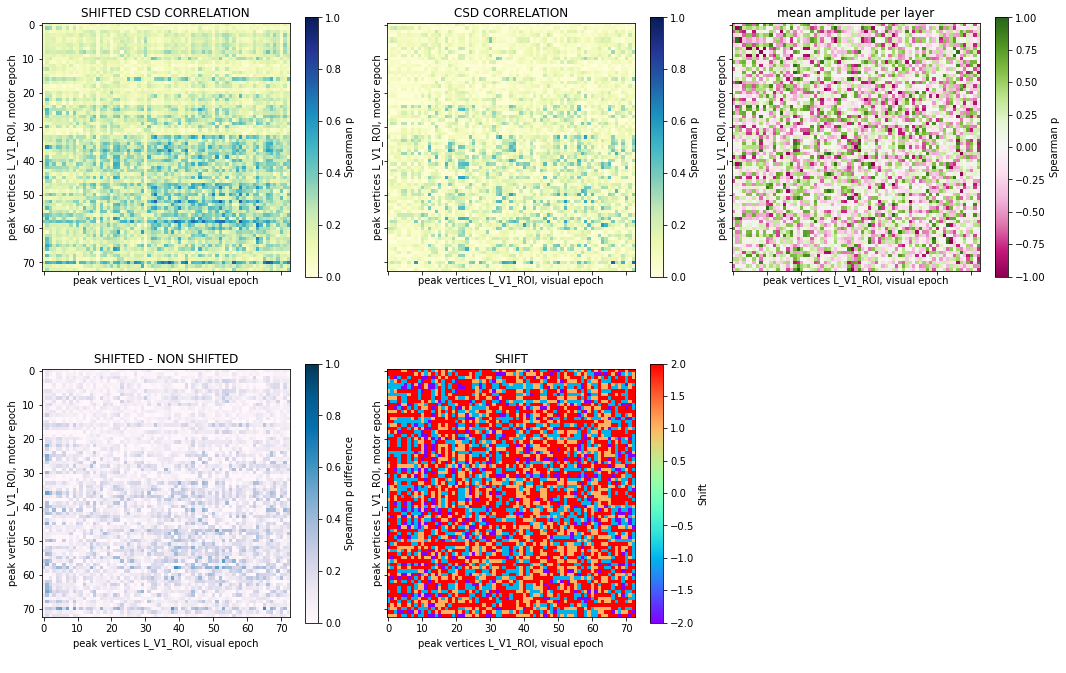

In [201]:
ser1 = (subs[0], list(settings.keys())[0], rois[1])
ser2 = (subs[0], list(settings.keys())[1], rois[1])
shape = roi_csds[ser1].shape[0]
r_res = np.zeros([shape, shape])
sr_res = np.zeros([shape, shape])
s_res = np.zeros([shape, shape])
m_res = np.zeros([shape, shape])

for r, c in list(it.product(range(shape), range(shape))):
    rx = np.array(np.split(roi_csds[ser1][r], 11))
    cy = np.array(np.split(roi_csds[ser2][c], 11))
    rs, p = spearmanr(rx.flatten(), cy.flatten())
    r_res[r, c] = rs
    sr, s = shift_cor(rx, cy)
    sr_res[r, c] = sr
    s_res[r, c] = s
    mx = np.mean(rx, axis=1)
    my = np.mean(cy, axis=1)
    mr, p = spearmanr(mx, my)
    m_res[r, c] = mr

f, ax = plt.subplots(2, 3, figsize=(15, 10), facecolor="white", sharey=True, sharex=True)
ax = ax.flatten()

c = 0
divnorm = colors.Normalize(vmin=0, vmax=1)
im = ax[c].imshow(np.abs(sr_res), origin="lower", norm=divnorm, cmap="YlGnBu")
ax[c].set_title("SHIFTED CSD CORRELATION")
ax[c].set_ylabel("peak vertices {}, {} epoch".format(ser1[2], ser1[1]))
ax[c].set_xlabel("peak vertices {}, {} epoch".format(ser2[2], ser2[1]))
plt.colorbar(im, ax=ax[c], shrink=0.75, label="Spearman p");

c = 1
divnorm = colors.Normalize(vmin=0, vmax=1)
im = ax[c].imshow(np.abs(r_res), origin="lower", norm=divnorm, cmap="YlGnBu")
ax[c].set_title("CSD CORRELATION")
ax[c].set_ylabel("peak vertices {}, {} epoch".format(ser1[2], ser1[1]))
ax[c].set_xlabel("peak vertices {}, {} epoch".format(ser2[2], ser2[1]))
plt.colorbar(im, ax=ax[c], shrink=0.75, label="Spearman p");

c = 3
divnorm = colors.Normalize(vmin=0, vmax=1)
im = ax[c].imshow(np.abs(sr_res)- np.abs(r_res), origin="lower", norm=divnorm, cmap="PuBu")
ax[c].set_title("SHIFTED - NON SHIFTED")
ax[c].set_ylabel("peak vertices {}, {} epoch".format(ser1[2], ser1[1]))
ax[c].set_xlabel("peak vertices {}, {} epoch".format(ser2[2], ser2[1]))
plt.colorbar(im, ax=ax[c], shrink=0.75, label="Spearman p difference");

c = 4
divnorm = colors.TwoSlopeNorm(0, vmin=-2, vmax=2)
im = ax[c].imshow(s_res, norm=divnorm, cmap="rainbow")
ax[c].set_title("SHIFT")
ax[c].set_ylabel("peak vertices {}, {} epoch".format(ser1[2], ser1[1]))
ax[c].set_xlabel("peak vertices {}, {} epoch".format(ser2[2], ser2[1]))
plt.colorbar(im, ax=ax[c], shrink=0.75, label="Shift");


c = 2
divnorm = colors.TwoSlopeNorm(0, vmin=-1, vmax=1)
im = ax[c].imshow(m_res, norm=divnorm, cmap="PiYG")
ax[c].set_title("mean amplitude per layer")
ax[c].set_ylabel("peak vertices {}, {} epoch".format(ser1[2], ser1[1]))
ax[c].set_xlabel("peak vertices {}, {} epoch".format(ser2[2], ser2[1]))
plt.colorbar(im, ax=ax[c], shrink=0.75, label="Spearman p");


ax[5].axis('off')
plt.tight_layout()
filename_template = "/home/mszul/git/DANC_multilayer_laminar/output/{}_{}_csd_across_epochs.{}"
plt.savefig(filename_template.format(ser1[0], ser1[2], "png"), dpi=300)

('sub-002', 'motor', 'L_V1_ROI') ('sub-002', 'visual', 'L_V1_ROI') 25 / 50


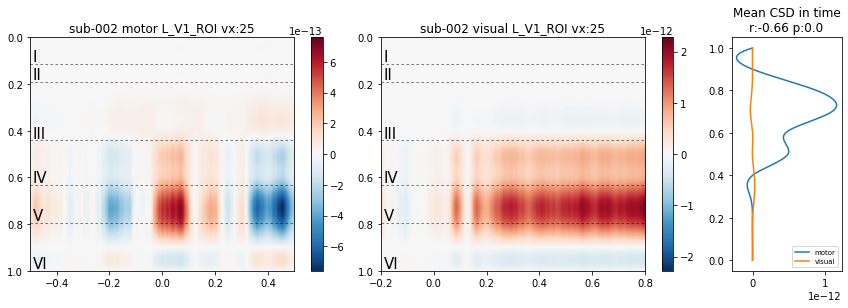

In [288]:
epoch_settings = {
    "visual": [np.linspace(-0.2, 0.8, num=601), [0.0, 0.2], -0.01],
    "motor": [np.linspace(-0.5, 0.5, num=601), [-0.2, 0.2], -0.2]
}

ser1 = (subs[1], list(settings.keys())[0], rois[1])
ser2 = (subs[1], list(settings.keys())[1], rois[1])
vx = 25
print(ser1, ser2, vx, "/", all_roi_csds[ser1].shape[0])

csd1 = all_roi_csds[ser1][vx]
csd2 = all_roi_csds[ser2][vx]

f, ax = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 3, 1]})

ax[0].set_title("{} {} {} vx:{}".format(*ser1, vx))
ax[1].set_title("{} {} {} vx:{}".format(*ser2, vx))
ax[1].set_title("{} {} {} vx:{}".format(*ser2, vx))

csd1 = smooth_csd(csd1, 11)
times, pca_sel, baseline_lim = epoch_settings[ser1[1]]
baseline1 = np.mean(csd1[:, np.where(times < baseline_lim)], axis=2)
csd1 = csd1 - baseline1
info = info_dict[ser1[0]]
atlas = pd.read_csv(info["atlas"])
atlas_labels = np.load(info["atlas_colors_path"])
ROI_labels = list(label_names.keys())
vertex_num = np.arange(atlas_labels.shape[0])
ROI_vertices = vertex_num[[ser1[2] == al.decode("utf=8") for al in atlas_labels]]
peak_mask = results[ser1[0]][ser1[2]]
ROI_vertices = ROI_vertices[peak_mask]
plot_csd(csd1, ROI_vertices, info["big_brain_layers_path"], times, ax=ax[0], cmap="RdBu_r")

csd2 = smooth_csd(csd2, 11)
times, pca_sel, baseline_lim = epoch_settings[ser2[1]]
baseline2 = np.mean(csd2[:, np.where(times < baseline_lim)], axis=2)
csd2 = csd2 - baseline2
info = info_dict[ser2[0]]
atlas = pd.read_csv(info["atlas"])
atlas_labels = np.load(info["atlas_colors_path"])
ROI_labels = list(label_names.keys())
vertex_num = np.arange(atlas_labels.shape[0])
ROI_vertices = vertex_num[[ser2[2] == al.decode("utf=8") for al in atlas_labels]]
peak_mask = results[ser2[0]][ser2[2]]
ROI_vertices = ROI_vertices[peak_mask]
plot_csd(csd2, ROI_vertices, info["big_brain_layers_path"], times, ax=ax[1], cmap="RdBu_r")

summ1 = np.mean(csd2, axis=1)
summ2 = np.mean(csd1, axis=1)
r, p = spearmanr(summ1, summ2)
ax[2].set_title("Mean CSD in time\nr:{} p:{}".format(round(r, 2), round(p, 3)))
ax[2].plot(summ1, np.linspace(1,0, num=summ1.shape[0]), label="{}".format(ser1[1]))
ax[2].plot(summ2, np.linspace(1,0, num=summ2.shape[0]), label="{}".format(ser2[1]))
ax[2].legend(loc=4, fontsize=7)